In [1]:
# # Install necessary libraries
# !pip install tensorflow
# !pip install tensorflow-addons

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# Data directories
data_dir = '/content/drive/MyDrive/cvpr_papers/images'

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2  # Using 20% for validation
)

# Training and validation generators
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Adjust according to model input size
    batch_size=16,
    class_mode='categorical',  # For multi-class classification
    subset='training'  # Set as training data
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',  # For multi-class classification
    subset='validation'  # Set as validation data
)


Found 288 images belonging to 9 classes.
Found 71 images belonging to 9 classes.


In [4]:
# Choose a base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
x = Dropout(0.3)(x)  # Dropout layer
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)  # Dropout layer
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)


In [5]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [6]:
# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)


In [7]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.3522 - loss: 28.2225
Epoch 1: val_accuracy improved from -inf to 0.87324, saving model to best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3732 - loss: 27.9341 - val_accuracy: 0.8732 - val_loss: 20.2565 - learning_rate: 0.0010
Epoch 2/20
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8709 - loss: 18.8442
Epoch 2: val_accuracy did not improve from 0.87324
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 696ms/step - accuracy: 0.8666 - loss: 18.6913 - val_accuracy: 0.8310 - val_loss: 14.4177 - learning_rate: 0.0010
Epoch 3/20
16/18 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step - accuracy: 0.9252 - loss: 13.3799
Epoch 3: val_accuracy did not improve from 0.87324
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 704ms/step - accuracy: 0.9233 - loss: 13.2263 - val_accuracy: 0.8732 - val_loss: 10.6081 - learning_rate: 0.0010
Epoch 4/20
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9492 - loss: 9.8723
Epoch 4: val_accuracy did not improve from 0.87

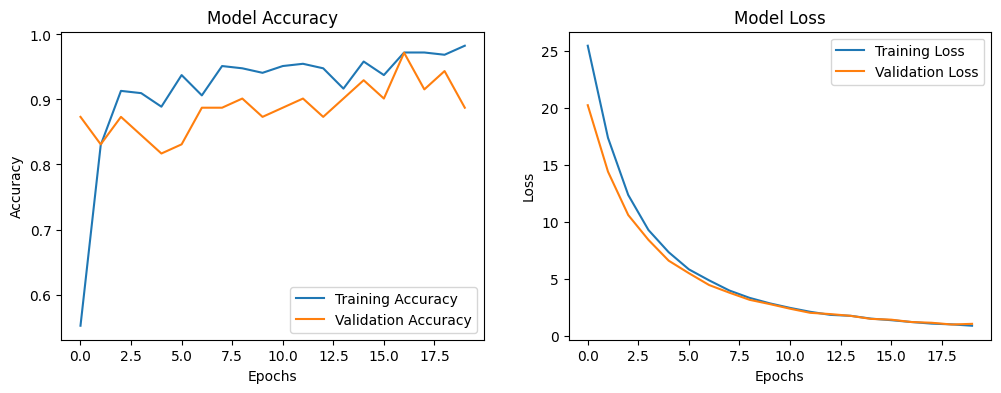

In [8]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()


In [11]:
# Function to create model
def create_model(base_model):
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
    x = Dropout(0.3)(x)  # Dropout layer
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)  # Dropout layer
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Training MobileNetV2...
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 943ms/step - accuracy: 0.3624 - loss: 27.9103 - val_accuracy: 0.8451 - val_loss: 20.4046 - learning_rate: 0.0010
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 614ms/step - accuracy: 0.7683 - loss: 18.9679 - val_accuracy: 0.8310 - val_loss: 14.5990 - learning_rate: 0.0010
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 714ms/step - accuracy: 0.8352 - loss: 13.4879 - val_accuracy: 0.9296 - val_loss: 10.6413 - learning_rate: 0.0010
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 760ms/step - accuracy: 0.9217 - loss: 9.8958 - val_accuracy: 0.9296 - val_loss: 8.1051 - learning_rate: 0.0010
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 697ms/step - accuracy: 0.9063 - loss: 7.7023 - val_accuracy: 0.9014 - val_loss: 6.4400 - learning_rate: 0.0010
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 647ms/step - accuracy: 0.9445 - loss: 6.0364 - val_accuracy: 0.9296 - val_loss: 5.2046 - learning_rate: 0.0010
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 653ms/step

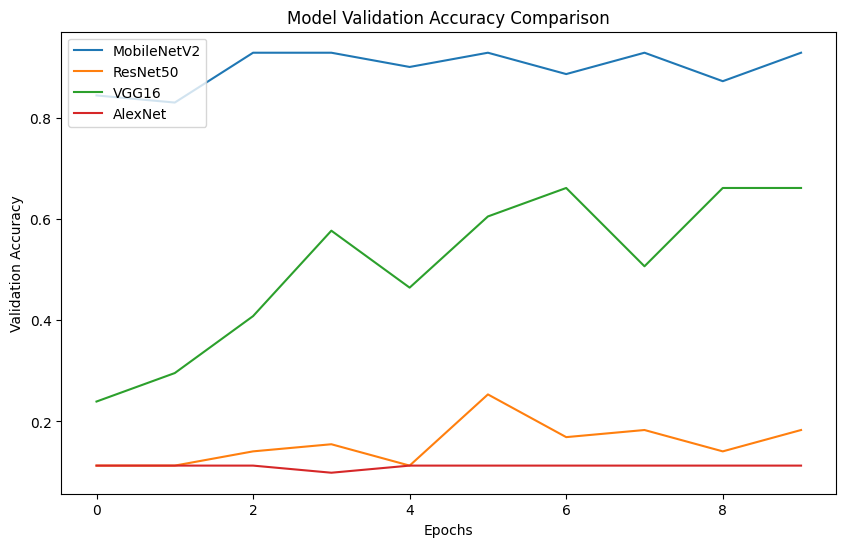

In [13]:
# Custom AlexNet model
def create_alexnet():
    model = Sequential()

    model.add(Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(train_generator.num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

# List to store history of each model
histories = {}
models = ['MobileNetV2', 'ResNet50', 'VGG16', 'AlexNet']

# Train MobileNetV2
print("Training MobileNetV2...")
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenetv2_model = create_model(base_model)

history_mobilenetv2 = mobilenetv2_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint, reduce_lr]
)
histories['MobileNetV2'] = history_mobilenetv2.history

# Train ResNet50
print("Training ResNet50...")
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_model = create_model(base_model)

history_resnet50 = resnet50_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint, reduce_lr]
)
histories['ResNet50'] = history_resnet50.history

# Train VGG16
print("Training VGG16...")
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_model = create_model(base_model)

history_vgg16 = vgg16_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint, reduce_lr]
)
histories['VGG16'] = history_vgg16.history

# Train AlexNet
print("Training AlexNet...")
alexnet_model = create_alexnet()

history_alexnet = alexnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint, reduce_lr]
)
histories['AlexNet'] = history_alexnet.history

# Plot the validation accuracy of all models
plt.figure(figsize=(10, 6))

for model_name, history in histories.items():
    plt.plot(history['val_accuracy'], label=model_name)

plt.title('Model Validation Accuracy Comparison')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

# Save models for later use
mobilenetv2_model.save('mobilenetv2_model.keras')
resnet50_model.save('resnet50_model.keras')
vgg16_model.save('vgg16_model.keras')
alexnet_model.save('alexnet_model.keras')

In [ ]:
# THE END